In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re


In [5]:
# Load both datasets
df_full = pd.read_csv("webreg_data/results/enrollment_comparison_shared.csv")
df_partial = pd.read_csv("webreg_data/results/enrollment_comparison_partial.csv")

df_full['offering_type'] = 'Fully Offered'
df_partial['offering_type'] = 'Partially Offered'

df_all = pd.concat([df_full, df_partial], ignore_index=True)

# Required vs Elective
required_courses = {
    'DSC_10', 'DSC_20', 'DSC_30', 'DSC_40A', 'DSC_40B',
    'DSC_80', 'DSC_100', 'DSC_102', 'DSC_106',
    'DSC_140A', 'DSC_140B', 'DSC_148',
    'DSC_180A', 'DSC_180B'
}

df_all['course_type'] = np.where(
    df_all['course'].isin(required_courses),
    'Required',
    'Elective'
)

df_all.head()

,course,quarter,quarter_label,enrolled,available,waitlisted,total,time,utilization_rate,waitlist_rate,available_rate,offering_type,course_type
0,DSC_10,fa24,Fall 2024,427,17,8,444,2024-11-24T22:03:51,96.17,1.8,3.83,Fully Offered,Required
1,DSC_10,sp25,Spring 2025,108,42,0,150,2025-05-15T03:50:50,72.00,0.0,28.00,Fully Offered,Required
2,DSC_10,wi25,Winter 2025,207,83,0,290,2025-01-31T12:41:46,71.38,0.0,28.62,Fully Offered,Required
3,DSC_20,fa24,Fall 2024,74,76,0,150,2024-11-24T22:03:52,49.33,0.0,50.67,Fully Offered,Required
4,DSC_20,sp25,Spring 2025,107,13,0,120,2025-05-15T03:50:51,89.17,0.0,10.83,Fully Offered,Required


# Plot — Capacity Stress Matrix

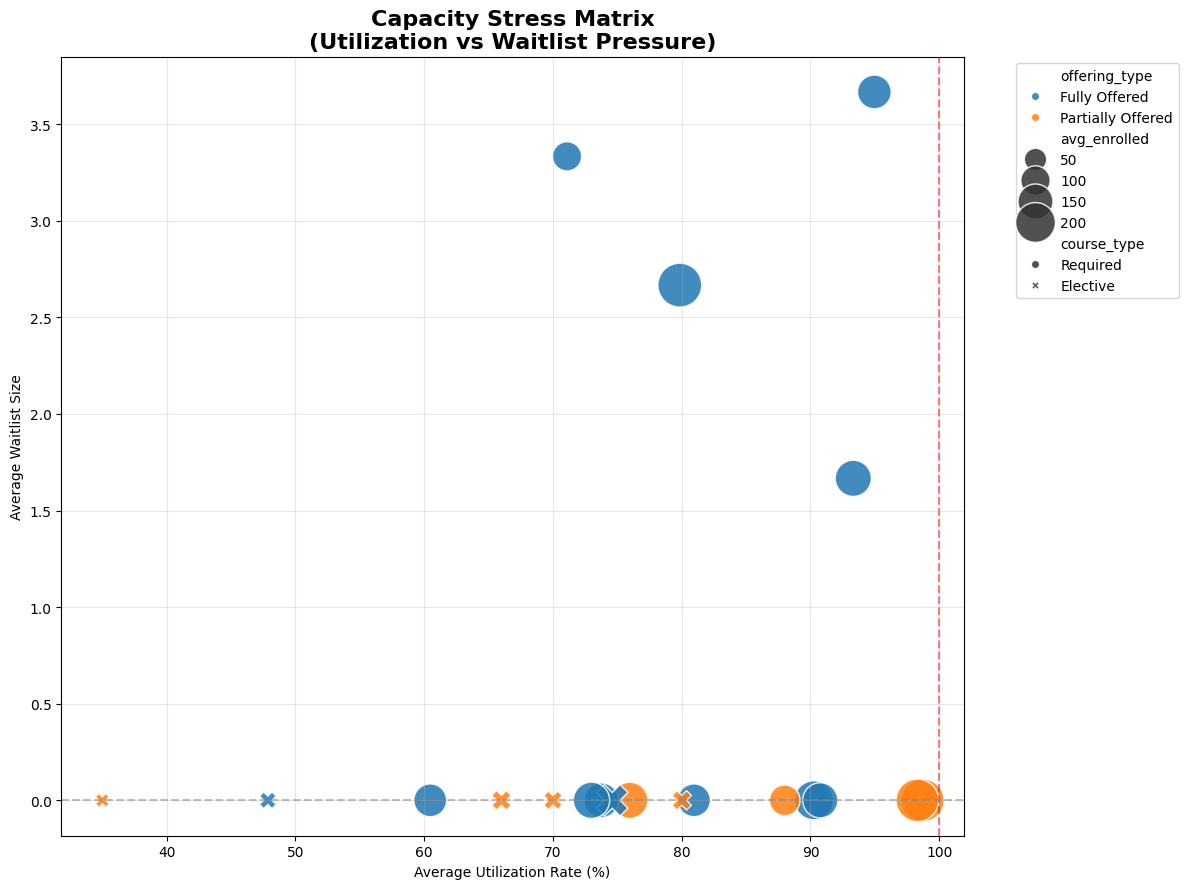

In [6]:
stress = (
    df_all
    .groupby(['course', 'offering_type', 'course_type'])
    .agg(
        avg_utilization=('utilization_rate', 'mean'),
        avg_waitlist=('waitlisted', 'mean'),
        avg_enrolled=('enrolled', 'mean')
    )
    .reset_index()
)

plt.figure(figsize=(12, 9))

sns.scatterplot(
    data=stress,
    x='avg_utilization',
    y='avg_waitlist',
    hue='offering_type',
    style='course_type',
    size='avg_enrolled',
    sizes=(100, 1000),
    alpha=0.85
)

plt.axvline(100, color='red', linestyle='--', alpha=0.5)
plt.axhline(stress['avg_waitlist'].median(), color='gray', linestyle='--', alpha=0.5)

plt.title(
    'Capacity Stress Matrix\n'
    '(Utilization vs Waitlist Pressure)',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Average Utilization Rate (%)')
plt.ylabel('Average Waitlist Size')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Offering Frequency vs Demand Efficiency

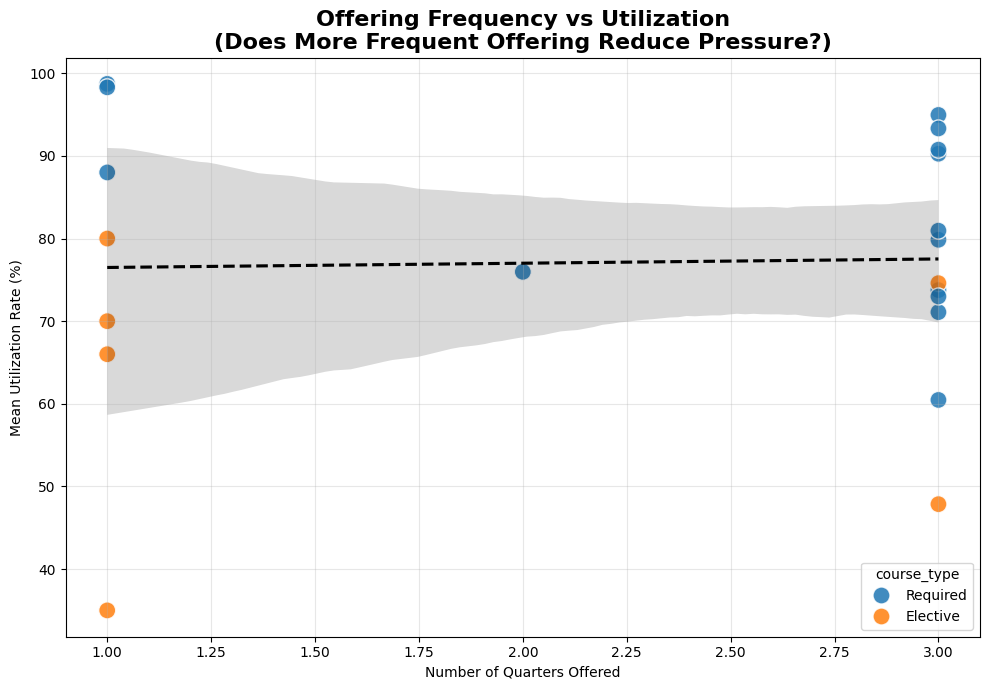

In [7]:
frequency = (
    df_all
    .groupby('course')
    .agg(
        quarters_offered=('quarter_label', 'nunique'),
        mean_utilization=('utilization_rate', 'mean'),
        course_type=('course_type', 'first')
    )
    .reset_index()
)

plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=frequency,
    x='quarters_offered',
    y='mean_utilization',
    hue='course_type',
    s=150,
    alpha=0.85
)

sns.regplot(
    data=frequency,
    x='quarters_offered',
    y='mean_utilization',
    scatter=False,
    color='black',
    line_kws={'linestyle': '--'}
)

plt.title(
    'Offering Frequency vs Utilization\n'
    '(Does More Frequent Offering Reduce Pressure?)',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Number of Quarters Offered')
plt.ylabel('Mean Utilization Rate (%)')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Plot — Enrollment vs Capacity (Combined)

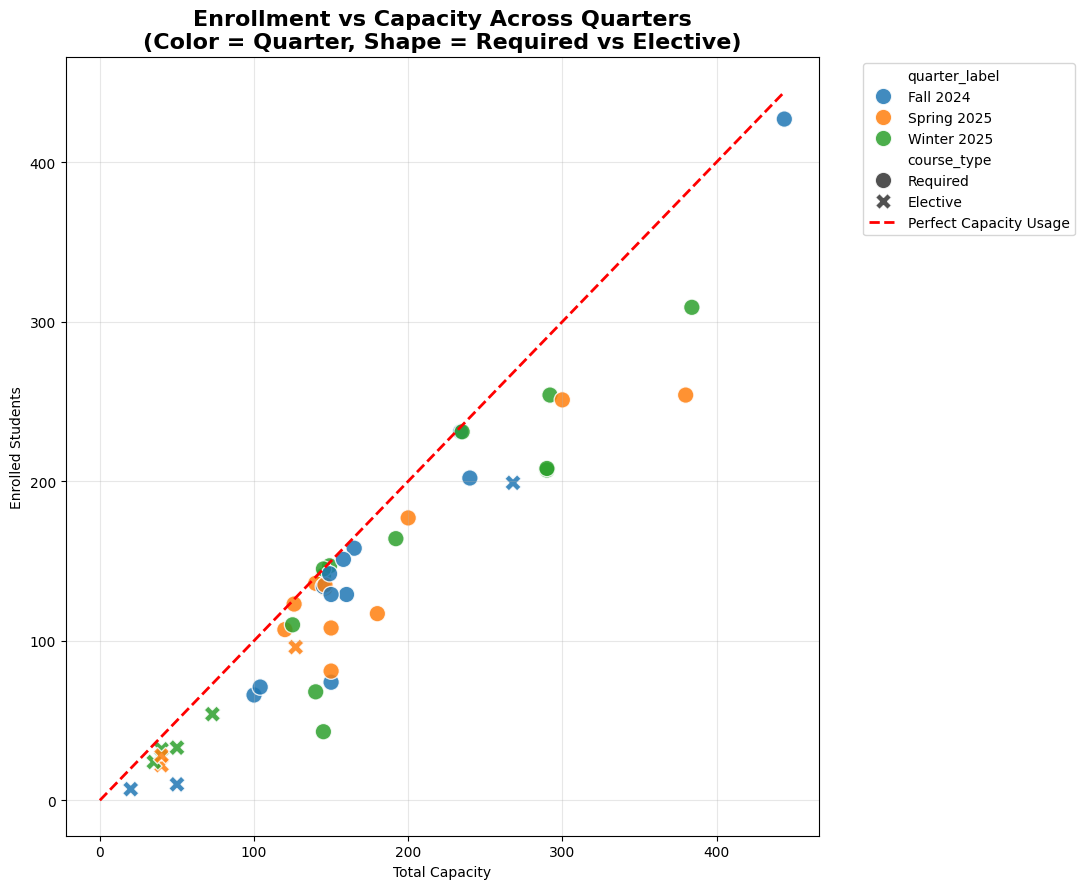

In [14]:
df = pd.concat([df_full, df_partial], ignore_index=True)

required_courses = {
    'DSC_10', 'DSC_20', 'DSC_30', 'DSC_40A', 'DSC_40B',
    'DSC_80', 'DSC_100', 'DSC_102', 'DSC_106',
    'DSC_140A', 'DSC_140B', 'DSC_148',
    'DSC_180A', 'DSC_180B'
}

df['course_type'] = np.where(
    df['course'].isin(required_courses),
    'Required',
    'Elective'
)


plt.figure(figsize=(11, 9))

sns.scatterplot(
    data=df,
    x='total',
    y='enrolled',
    hue='quarter_label',        # Quarter comparison
    style='course_type',        # Required vs Elective
    s=140,
    alpha=0.85
)

# Perfect capacity reference
max_cap = df['total'].max()
plt.plot(
    [0, max_cap],
    [0, max_cap],
    'r--',
    linewidth=2,
    label='Perfect Capacity Usage'
)

plt.title(
    'Enrollment vs Capacity Across Quarters\n'
    '(Color = Quarter, Shape = Required vs Elective)',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Total Capacity')
plt.ylabel('Enrolled Students')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



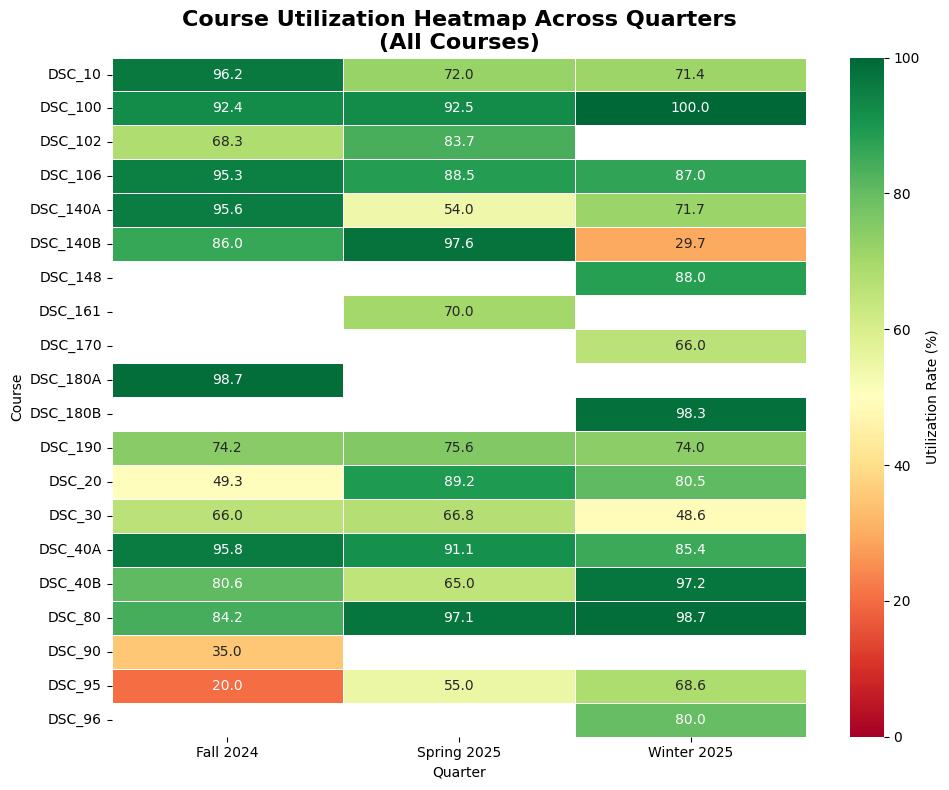

In [15]:
# Pivot utilization across all courses and quarters
pivot_util = (
    df
    .pivot_table(
        index='course',
        columns='quarter_label',
        values='utilization_rate',
        aggfunc='mean'
    )
    .sort_index()
)

plt.figure(figsize=(10, max(8, len(pivot_util) * 0.35)))

sns.heatmap(
    pivot_util,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    vmin=0,
    vmax=100,
    linewidths=0.5,
    cbar_kws={'label': 'Utilization Rate (%)'}
)

plt.title(
    'Course Utilization Heatmap Across Quarters\n'
    '(All Courses)',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Quarter')
plt.ylabel('Course')
plt.tight_layout()
plt.show()


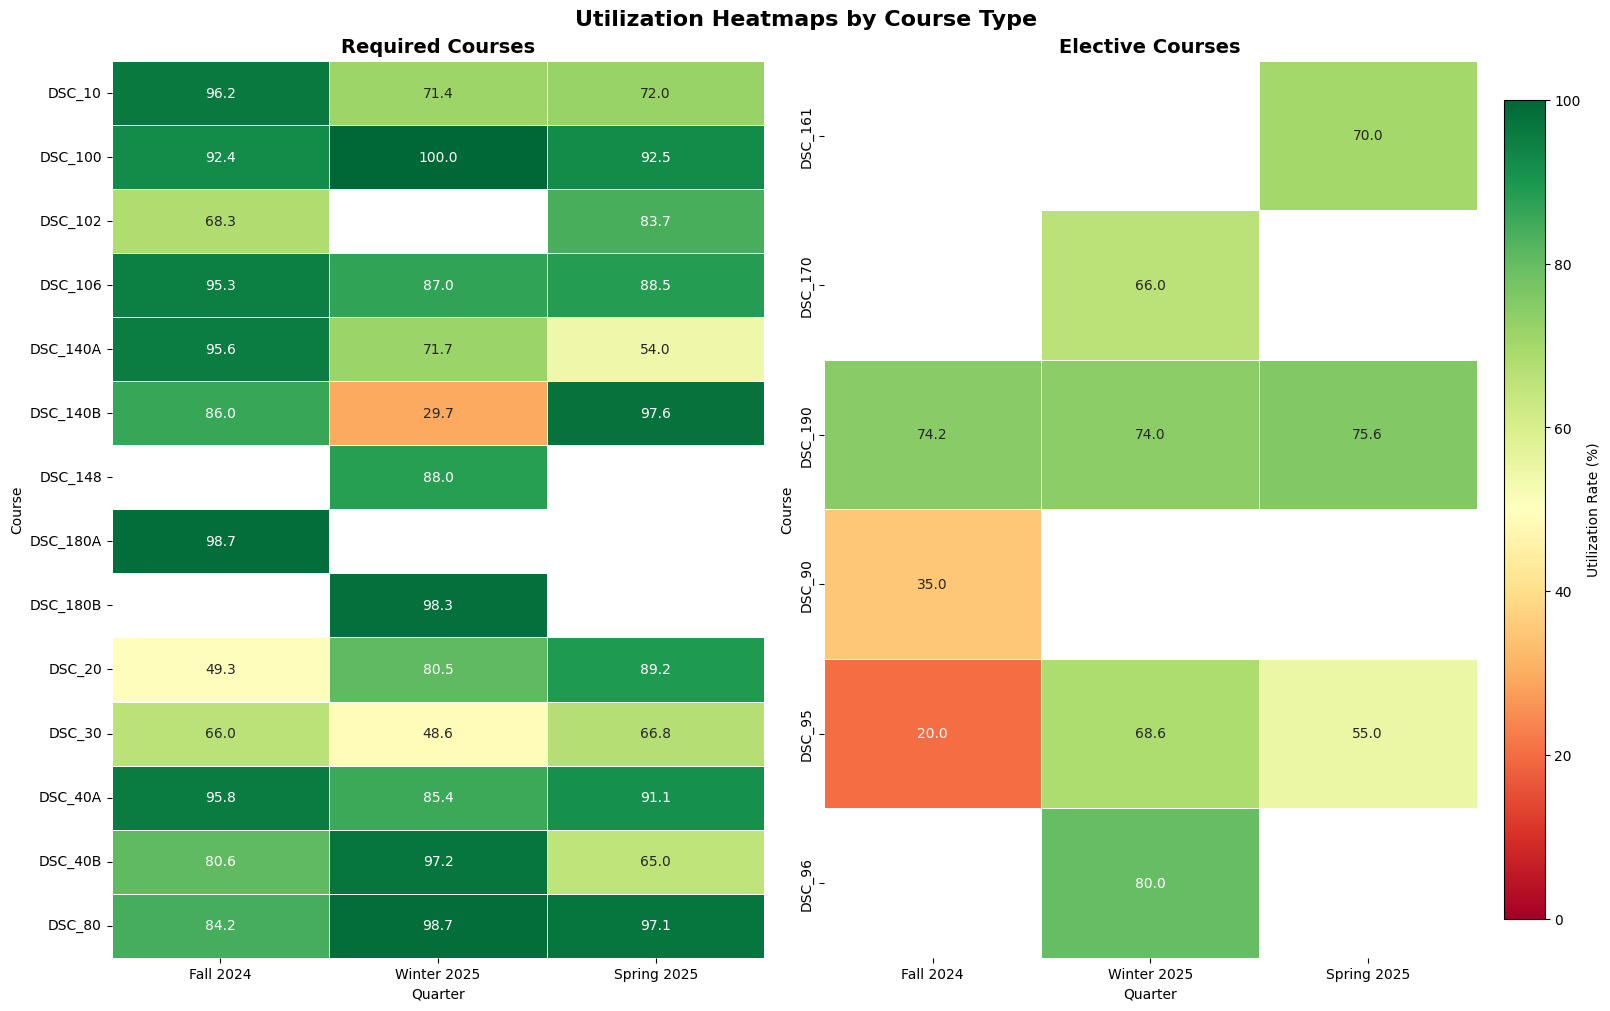

In [18]:
quarter_order = ['Fall 2024', 'Winter 2025', 'Spring 2025']

fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 10),
    constrained_layout=True
)

for ax, ctype in zip(axes, ['Required', 'Elective']):
    subset = df[df['course_type'] == ctype]

    pivot = (
        subset
        .pivot_table(
            index='course',
            columns='quarter_label',
            values='utilization_rate',
            aggfunc='mean'
        )
        .reindex(columns=quarter_order)
    )

    sns.heatmap(
        pivot,
        annot=True,
        fmt='.1f',
        cmap='RdYlGn',
        vmin=0,
        vmax=100,
        linewidths=0.5,
        linecolor='white',
        mask=pivot.isna(),          # ← important
        cbar=False,
        ax=ax
    )

    ax.set_title(f'{ctype} Courses', fontsize=14, fontweight='bold')
    ax.set_xlabel('Quarter')
    ax.set_ylabel('Course')
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', rotation=0)

# Shared colorbar (correctly attached)
cbar = fig.colorbar(
    axes[0].collections[0],
    ax=axes,
    orientation='vertical',
    fraction=0.03,
    pad=0.02
)
cbar.set_label('Utilization Rate (%)')

fig.suptitle(
    'Utilization Heatmaps by Course Type',
    fontsize=16,
    fontweight='bold'
)

plt.show()


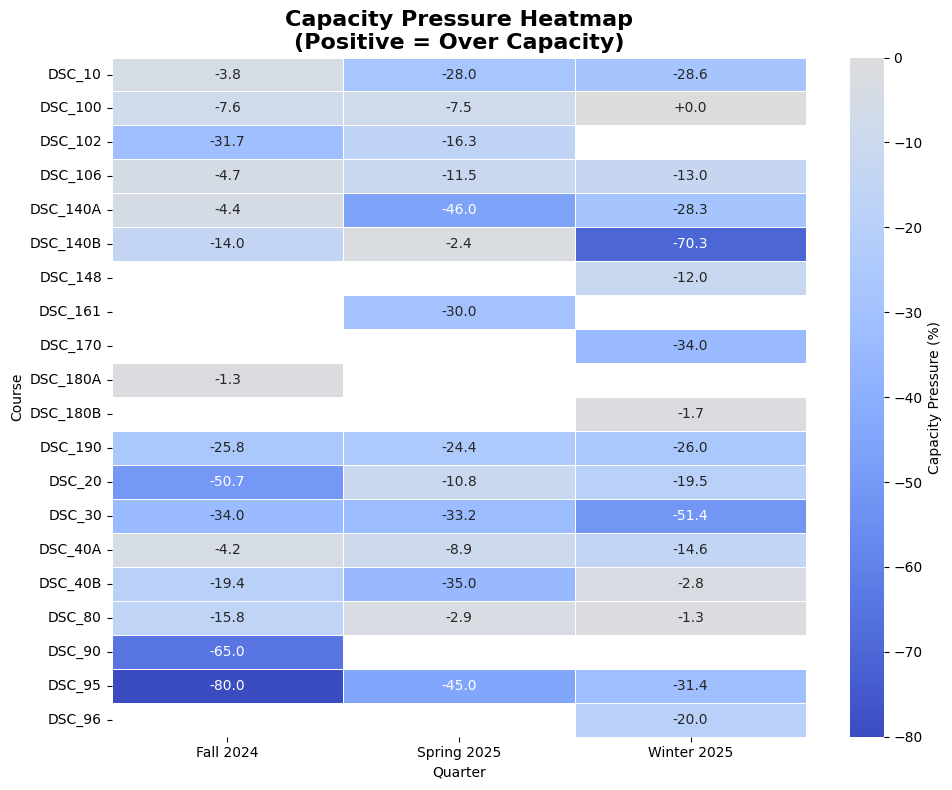

In [17]:
df['capacity_pressure'] = df['utilization_rate'] - 100

pivot_pressure = df.pivot_table(
    index='course',
    columns='quarter_label',
    values='capacity_pressure',
    aggfunc='mean'
)

plt.figure(figsize=(10, max(8, len(pivot_pressure) * 0.35)))

sns.heatmap(
    pivot_pressure,
    annot=True,
    fmt='+.1f',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Capacity Pressure (%)'}
)

plt.title(
    'Capacity Pressure Heatmap\n'
    '(Positive = Over Capacity)',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Quarter')
plt.ylabel('Course')
plt.tight_layout()
plt.show()
